<a href="https://www.kaggle.com/code/averma111/lightning-timeseries?scriptVersionId=136716494" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [28]:
# Re-loads all imports every time the cell is ran. 
%reload_ext autoreload

from time import time

import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.5f}'.format

from IPython.display import display

# Sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Neural Networks
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e19/sample_submission.csv
/kaggle/input/playground-series-s3e19/train.csv
/kaggle/input/playground-series-s3e19/test.csv


In [29]:
class TimeseriesDataset(Dataset):   
    def __init__(self, X: np.ndarray, y: np.ndarray, seq_len: int = 1):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])

In [30]:
class TimeseriesDatasetTest(Dataset):   
    def __init__(self, X: np.ndarray, seq_len: int = 1):
        self.X = torch.tensor(X).float()
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len])

In [31]:
class FeatureGeneration:
    
    def datetime_features(self,df):
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
        df['year'] = df['date'].dt.year
        df['dayofweek'] = df['date'].dt.dayofweek
        df['quarter'] = df['date'].dt.quarter
        df['dayofmonth'] = df['date'].dt.day
        df['weekofyear'] = df['date'].dt.weekofyear
        return df
    
    def seasonality_features(df):
        df['month_sin'] = np.sin(2*np.pi*df.month/12)
        df['month_cos'] = np.cos(2*np.pi*df.month/12)
        df['day_sin'] = np.sin(2*np.pi*df.day/24)
        df['day_cos'] = np.cos(2*np.pi*df.day/24)
        return df_temp

In [32]:
from sklearn.preprocessing import LabelEncoder
class ForecastingDataModule(pl.LightningDataModule):
    
    def __init__(self, seq_len = 1, batch_size = 128, num_workers=0):
        super().__init__()
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.X_train = None
        self.y_train = None
        self.X_val = None
        self.y_val = None
        self.X_test = None
        self.X_test = None
        self.columns = None
        self.preprocessing = None

    def prepare_data(self):
        path = '/kaggle/input/playground-series-s3e19/train.csv'
        df = pd.read_csv(
            path, 
            sep=',', 
            parse_dates=['date'], 
            infer_datetime_format=True, 
            low_memory=False
        )

        X = df.copy()
        X['store'] =  LabelEncoder().fit_transform(X['store'])
        X['product'] =  LabelEncoder().fit_transform(X['product'])
        X['country'] =  LabelEncoder().fit_transform(X['country'])
        X = X.loc[:, X.columns!='id']
        y = X['num_sold']
        X.drop(columns=['date','num_sold'],axis=1,inplace=True)
        self.columns = X.columns
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.25, shuffle=False
        )
        #print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)
        self.X_train=X_train
        self.X_val = X_val
        self.y_train = y_train
        self.y_val = y_val

    def setup(self, stage=None):
        preprocessing = StandardScaler()
        if stage == 'fit':
            self.X_train = preprocessing.fit_transform(self.X_train)
            self.y_train = self.y_train.values
            self.X_val = preprocessing.fit_transform(self.X_val)
            self.y_val = self.y_val.values

        if stage == 'test':
            self.X_test = preprocessing.fit_transform(self.X_test)
            
        

    def train_dataloader(self):
        train_dataset = TimeseriesDataset(self.X_train, 
                                          self.y_train, 
                                          seq_len=self.seq_len)
        train_loader = DataLoader(train_dataset, 
                                  batch_size = self.batch_size, 
                                  shuffle = False, 
                                  num_workers = self.num_workers)
        
        return train_loader

    def val_dataloader(self):
        val_dataset = TimeseriesDataset(self.X_val, 
                                        self.y_val, 
                                        seq_len=self.seq_len)
        val_loader = DataLoader(val_dataset, 
                                batch_size = self.batch_size, 
                                shuffle = False, 
                                num_workers = self.num_workers)

        return val_loader
    
    
    def prepare_data_test(self):
        path = '/kaggle/input/playground-series-s3e19/test.csv'
        df = pd.read_csv(
            path, 
            sep=',', 
            parse_dates=['date'], 
            infer_datetime_format=True, 
            low_memory=False
        )

        X = df.copy()
        X['store'] =  LabelEncoder().fit_transform(X['store'])
        X['product'] =  LabelEncoder().fit_transform(X['product'])
        X['country'] =  LabelEncoder().fit_transform(X['country'])
        X = X.loc[:, X.columns!='id']
        X.drop(columns=['date'],axis=1,inplace=True)
        self.columns = X.columns
        self.X_test = X

    def test_dataloader(self):
        test_dataset = TimeseriesDatasetTest(self.X_test,
                                         seq_len=self.seq_len)
        test_loader = DataLoader(test_dataset, 
                                 batch_size = self.batch_size, 
                                 shuffle = False, 
                                 num_workers = self.num_workers)

        return test_loader

In [33]:
class LSTMRegressor(pl.LightningModule):
    def __init__(self, 
                 n_features, 
                 hidden_size, 
                 seq_len, 
                 batch_size,
                 num_layers, 
                 #dropout, 
                 learning_rate,
                 criterion):
        super(LSTMRegressor, self).__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_layers = num_layers
        #self.dropout = dropout
        self.criterion = criterion
        self.learning_rate = learning_rate

        self.lstm = nn.LSTM(input_size=n_features, 
                            hidden_size=hidden_size,
                            num_layers=num_layers, 
                            #dropout=dropout, 
                            batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        y_pred = self.linear(lstm_out[:,-1])
        return y_pred
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.learning_rate,momentum=0.9)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('Train_loss', loss)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('Validation_loss', loss)
    

In [34]:
p = dict(
    seq_len = 24,
    batch_size = 128, 
    criterion = nn.MSELoss(),
    max_epochs = 10,
    n_features = 3,
    hidden_size = 1,
    num_layers = 1,
    #dropout = 0.2,
    learning_rate = 0.001,
)

In [35]:
seed_everything(1)
csv_logger = CSVLogger('./', name='lstm', version='0'),

model = LSTMRegressor(
    n_features = p['n_features'],
    hidden_size = p['hidden_size'],
    seq_len = p['seq_len'],
    batch_size = p['batch_size'],
    criterion = p['criterion'],
    num_layers = p['num_layers'],
    #dropout = p['dropout'],
    learning_rate = p['learning_rate']
)



In [36]:
print(model)

LSTMRegressor(
  (criterion): MSELoss()
  (lstm): LSTM(3, 1, batch_first=True)
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


In [37]:
trainer = Trainer(
    max_epochs=p['max_epochs'],
    logger=csv_logger,
    accelerator='auto',
    log_every_n_steps=1
)

In [38]:
dm = ForecastingDataModule(
    seq_len = p['seq_len'],
    batch_size = p['batch_size']
)
dm.prepare_data()


In [39]:
trainer.fit(model, dm)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

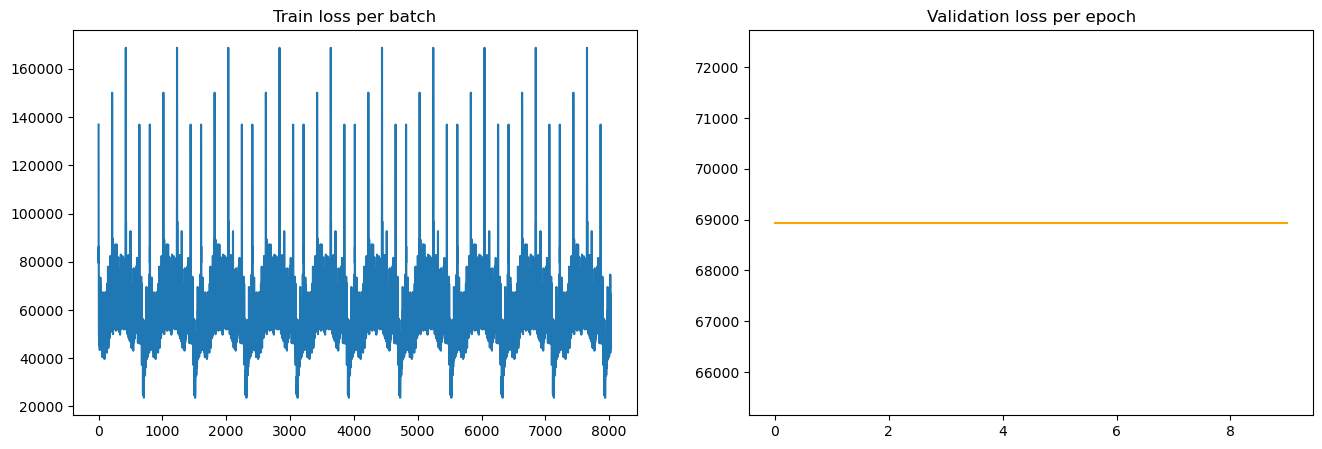

MSE:
Train loss: 44299.906
Val loss:   68939.227


In [40]:
metrics = pd.read_csv('./lstm/0/metrics.csv')
train_loss = metrics[['Train_loss', 'step', 'epoch']][~np.isnan(metrics['Train_loss'])]
val_loss = metrics[['Validation_loss', 'epoch']][~np.isnan(metrics['Validation_loss'])]

fig, axes = plt.subplots(1, 2, figsize=(16, 5), dpi=100)
axes[0].set_title('Train loss per batch')
axes[0].plot(train_loss['step'], train_loss['Train_loss'])
axes[1].set_title('Validation loss per epoch')
axes[1].plot(val_loss['epoch'], val_loss['Validation_loss'], color='orange')
plt.show(block = True)

print('MSE:')
print(f"Train loss: {train_loss['Train_loss'].iloc[-1]:.3f}")
print(f"Val loss:   {val_loss['Validation_loss'].iloc[-1]:.3f}")

In [42]:
dm.prepare_data_test()
trainer.test(model, datamodule=dm)

Testing: 0it [00:00, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 dm.prepare_data_test()                                                                       │
│ ❱ 2 trainer.test(model, datamodule=dm)                                                           │
│   3                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:737 in test         │
│                                                                                                  │
│    734 │   │   else:                                                                             │
│    735 │   │   │   model = _maybe_unwrap_optimized(model)                                        │
│    736 │   │   │   self.strategy._lightning_module = model                                       │
│ ❱  737 │   │   return call._call_and_handle_interrupt(                                           │
│    738 │   │   │   self, self._test_impl, model, dataloaders, ckpt_path, verbose, datamodule     │
│    739 │   │   )                                                                                 │
│    740                                                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:42 in                  │
│ _call_and_handle_interrupt                                                                       │
│                                                                                                  │
│    39 │   try:                                                                                   │
│    40 │   │   if trainer.strategy.launcher is not None:                                          │
│    41 │   │   │   return trainer.strategy.launcher.launch(trainer_fn, *args, trainer=trainer,    │
│ ❱  42 │   │   return trainer_fn(*args, **kwargs)                                                 │
│    43 │                                                                                          │
│    44 │   except _TunerExitException:                                                            │
│    45 │   │   _call_teardown_hook(trainer)                                                       │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:780 in _test_impl   │
│                                                                                                  │
│    777 │   │   ckpt_path = self._checkpoint_connector._select_ckpt_path(                         │
│    778 │   │   │   self.state.fn, ckpt_path, model_provided=model_provided, model_connected=sel  │
│    779 │   │   )                                                                                 │
│ ❱  780 │   │   results = self._run(model, ckpt_path=ckpt_path)                                   │
│    781 │   │   # remove the tensors from the test results                                        │
│    782 │   │   results = convert_tensors_to_scalars(results)                                     │
│    783                                                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:975 in _run         │
│                                                            

In [ ]:
metrics = pd.read_csv('./lstm/0/metrics_test.csv')
test_loss = metrics['Test_loss'].iloc[-1]

fig, axes = plt.subplots(1, 1, figsize=(16, 5), dpi=100)
axes[0].set_title('Test loss per batch')
axes[0].plot(test_loss['step'], test_loss['Test_loss'])
plt.show(block = True)

print('MSE:')
print(f'Test loss: {test_loss:.3f}')